In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
import tensorflow as tf 
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [68]:
data = pd.read_csv('/content/train.csv')
data['hour']  = [ str(i)+':0:0' for i in data['hour']]
data['datetime'] =  pd.to_datetime(data['date'] + ' ' + data['hour'])
data = data[['datetime','demand']]
data.head()

,datetime,demand
0,2018-08-18 09:00:00,91
1,2018-08-18 10:00:00,21
2,2018-08-18 13:00:00,23
3,2018-08-18 14:00:00,104
4,2018-08-18 15:00:00,81


In [75]:
test_data =pd.read_csv("/content/test.csv")
test_data['hour']  = [ str(i)+':0:0' for i in test_data['hour']]
test_data['datetime'] =  pd.to_datetime(test_data['date'] + ' ' + test_data['hour'])
test_data = pd.DataFrame(test_data['datetime'])
test_data.head()

,datetime
0,2021-03-01 00:00:00
1,2021-03-01 01:00:00
2,2021-03-01 02:00:00
3,2021-03-01 03:00:00
4,2021-03-01 05:00:00


In [76]:
data.shape,test_data.shape

((18247, 2), (7650, 1))

In [81]:
df = pd.concat([data,test_data],axis=0)
df.head()

,datetime,demand
0,2018-08-18 09:00:00,91.0
1,2018-08-18 10:00:00,21.0
2,2018-08-18 13:00:00,23.0
3,2018-08-18 14:00:00,104.0
4,2018-08-18 15:00:00,81.0


In [82]:
df.tail()

,datetime,demand
7645,2022-03-28 19:00:00,NaN
7646,2022-03-28 20:00:00,NaN
7647,2022-03-28 21:00:00,NaN
7648,2022-03-28 22:00:00,NaN
7649,2022-03-28 23:00:00,NaN


In [83]:
fig = px.line(data, x="datetime", y=['demand'])
fig.show()

In [85]:
data = df.set_index('datetime')
data.head()

,demand
datetime,
2018-08-18 09:00:00,91.0
2018-08-18 10:00:00,21.0
2018-08-18 13:00:00,23.0
2018-08-18 14:00:00,104.0
2018-08-18 15:00:00,81.0


In [86]:
train_size = 18247

test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]
print(len(train), len(test))

18247 7650


In [88]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])

       
ad_test(train['demand'])

1. ADF :  -12.543616615314859
2. P-Value :  2.285775462202084e-23
3. Num Of Lags :  22


In [89]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [90]:
scaled_train[:10]

array([[0.23809524],
       [0.05291005],
       [0.05820106],
       [0.27248677],
       [0.21164021],
       [0.0952381 ],
       [0.06878307],
       [0.17195767],
       [0.20899471],
       [0.13492063]])

In [91]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 10
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [92]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.23809524 0.05291005 0.05820106 0.27248677 0.21164021 0.0952381
 0.06878307 0.17195767 0.20899471 0.13492063]
Predict this y: 
 [[0.01322751]]


In [93]:
X.shape

(1, 10, 1)

In [94]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [95]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [96]:
# fit model
history = model.fit(generator,epochs=5)

Epoch 1/5
18237/18237 [==============================] - 96s 5ms/step - loss: 0.0089
Epoch 2/5
18237/18237 [==============================] - 94s 5ms/step - loss: 0.0085
Epoch 3/5
18237/18237 [==============================] - 93s 5ms/step - loss: 0.0084
Epoch 4/5
18237/18237 [==============================] - 93s 5ms/step - loss: 0.0083
Epoch 5/5
18237/18237 [==============================] - 93s 5ms/step - loss: 0.0083


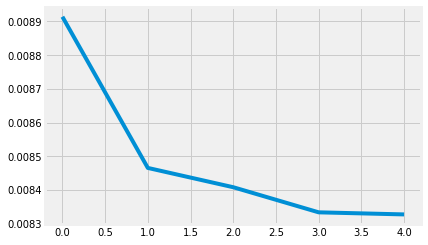

In [98]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [99]:
last_train_batch = scaled_train[-10:]
last_train_batch

array([[0.26455026],
       [0.22751323],
       [0.44179894],
       [0.25661376],
       [0.32010582],
       [0.24867725],
       [0.23015873],
       [0.1005291 ],
       [0.27248677],
       [0.22222222]])

In [100]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
last_train_batch 

array([[[0.26455026],
        [0.22751323],
        [0.44179894],
        [0.25661376],
        [0.32010582],
        [0.24867725],
        [0.23015873],
        [0.1005291 ],
        [0.27248677],
        [0.22222222]]])

In [101]:
model.predict(last_train_batch)

array([[0.18561682]], dtype=float32)

In [102]:
scaled_test[0]

array([nan])

In [103]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [104]:
len(test_predictions)

7650

[0.16618778, 0.17306674, 0.17911716, 0.18413165, 0.18507501]

In [105]:
predi = scaler.inverse_transform(test_predictions)
predi

array([[71.16315836],
       [67.87365216],
       [65.76229689],
       ...,
       [71.74967378],
       [71.74967378],
       [71.74967378]])

In [106]:
test_predict = [i[0] for i in predi]
test_predict[:5]

[71.1631583571434,
 67.8736521601677,
 65.762296885252,
 68.50080144405365,
 68.65947288274765]

In [49]:
fig = px.line(test, x=test.index, y=['demand',test_predict])
fig.show()

In [48]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['demand'],test_predict))
print(rmse)
print(mean_squared_error(test['demand'],test_predict))

46.13612801363361
2128.542308090388


In [107]:
test_data =pd.read_csv("/content/test.csv")
test_data['hour']  = [ str(i)+':0:0' for i in test_data['hour']]
test_data['datetime'] =  pd.to_datetime(test_data['date'] + ' ' + test_data['hour'])
test_data = test_data['datetime']
test_data.head()

0   2021-03-01 00:00:00
1   2021-03-01 01:00:00
2   2021-03-01 02:00:00
3   2021-03-01 03:00:00
4   2021-03-01 05:00:00
Name: datetime, dtype: datetime64[ns]

In [109]:
test_df =pd.read_csv("/content/test.csv")
test_df['demand'] = test_predict
test_df.head()

,date,hour,demand
0,2021-03-01,0,71.163158
1,2021-03-01,1,67.873652
2,2021-03-01,2,65.762297
3,2021-03-01,3,68.500801
4,2021-03-01,5,68.659473


In [110]:
test_df.to_csv("job.csv",index=False)